# Reinforcement learning

## An interactive notebook training Keras to play Catch

This is an interactive version of [Eder Santana's](http://edersantana.github.io/) [Keras plays catch, a single file Reinforcement Learning example](https://edersantana.github.io/articles/keras_rl/). The first interactive version of the original code was written by [cadurosar](https://gist.github.com/cadurosar/bd54c723c1d6335a43c8). I added comments and explanations, following the explanation laid out in [Demystifying Deep Reinforcement Learning](http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/) by [Tambet Matiisen](https://github.com/tambetm/). Please visit all the aforementioned authors websites for more information and give them credit for doing all the heavy lifting. This code is realeased under an MIT license, but please be aware that Google has the patent for Q-Learning.


## The task

Catch is a very simple arcade game, which you might have played as a child. Fruits are falling from the top of the screen and the player has to catch them with a basket. For every fruit caught, the player gets a point. For every fruit lost, the player looses a point. Our goal here is to let the computer play Catch by itself.

When playing Catch, the player has to decide between 3 possible actions. The player can move the basket to the left, to the right, or stay put. The basis for this decision is the current state of the game, the position of the fruit and the position of the basket, which are both visible on the screen. Our goal is therefore to create a model, which, given the content of the game screen, chooses the action which leads to the highest score possible.

This task could be framed as a simple classification problem. We could collect training data by letting expert human players play lots of games and then train a model on choosing the 'correct' action that mirrors the expert players. This is not how humans learn however. Humans can learn a game like catch by themselves, without guidiance. This is very useful. Imagine you would have to hire a bunch of experts to perform a task thousands of times everytime you wanted to learn something as simple as Catch. It would be very expensive and very slow. Here, we are going to demonstrate a technique called reinforcement learning, where the model learns from experience, rather than labeled training data.

In [1]:
#First we import some libraries
#Json for loading and saving the model (optional)
import json
#matplotlib for rendering
import matplotlib.pyplot as plt
#numpy for handeling matrix operations
import numpy as np
#time, to, well... keep track of time
import time
#Python image libarary for rendering
from PIL import Image
#iPython display for making sure we can render the frames
from IPython import display
#seaborn for rendering
import seaborn
#Keras is a deep learning libarary
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd

#Setup matplotlib so that it runs nicely in iPython
%matplotlib inline
#setting up seaborn
seaborn.set()

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


# Setting up the game

This is the code for the actual game we are training on.
Catch is a simple game you might have played as a child. In the game, fruits, represented by white tiles, fall from the top. The goal is to catch the fruits with a basked (represented by white tiles, this is deep learning, not game design). If you catch a fruit, you get a point (your score goes up by one), if you miss a fruit, you loose one (your score goes down).

Don't worry all too much about the details of the implementation, the focus here should be on the AI, not on the game.
Just make sure you run this cell so that it is defined.

In [2]:
class Catch(object):
    """
    Class catch is the actual game.
    In the game, fruits, represented by white tiles, fall from the top.
    The goal is to catch the fruits with a basked (represented by white tiles, this is deep learning, not game design).
    """
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas
        
    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]

In addition to defining the game we need to define some helper variables and functions.
Run the cells below to define them, then we will get to the meat and the potatoes of this notebook.

In [3]:
"""
Here we define some variables used for the game and rendering later
"""
#last frame time keeps track of which frame we are at
last_frame_time = 0
#translate the actions to human readable words
translate_action = ["Left","Stay","Right","Create Ball","End Test"]
#size of the game field
grid_size = 10

In [4]:
def display_screen(action,points,input_t):
    #Function used to render the game screen
    #Get the last rendered frame
    global last_frame_time
    print("Action %s, Points: %d" % (translate_action[action],points))
    #Only display the game screen if the game is not over
    if("End" not in translate_action[action]):
        #Render the game with matplotlib
        plt.imshow(input_t.reshape((grid_size,)*2),
               interpolation='none', cmap='gray')
        #Clear whatever we rendered before
        display.clear_output(wait=True)
        #And display the rendering
        display.display(plt.gcf())
    #Update the last frame time
    last_frame_time = set_max_fps(last_frame_time)
    
    
def set_max_fps(last_frame_time,FPS = 1):
    current_milli_time = lambda: int(round(time.time() * 1000))
    sleep_time = 1./FPS - (current_milli_time() - last_frame_time)
    if sleep_time > 0:
        time.sleep(sleep_time)
    return current_milli_time()

# Deep reinforcement learning

After the game is all setup, let's get to the exciting part.

For a deeper understanding of what is going on in the next couple of cells, definetly check out [Demystifying Deep Reinforcement Learning](http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/) and the links posted at the end of Tambet's post.

## Q-learning intuition.

A good way to understand Q-learning is to compare playing Catch with playing chess. In both games you are given a state s (chess: positions of the figures on the board, Catch: location of the fruit and the basket), on which you have to take an action a (chess: move a figure, Catch: move the basket to the left, right, or stay where you are). As a result there will be some reward r and a new state s’. The problem with both Catch and and chess is that the rewards will not appear immediately after you have taken the action. In Catch, you only earn rewards when the fruits hit the basket or fall on the floor, and in chess you only earn a reward when you win or loose the game. Rewards are _sparsely distributed_, most of the time, r will be 0. When there is a reward, it is not always a result of the action taken immediately before. Some action taken long before might have cause the victory. Figuring out which action is responsible for the reward is often referred to as the _credit assignment problem_.

Because rewards are delayed, good chess players do not choose their plays only by the immediate reward, but by the _expected future reward_. They do not only think about whether they can eliminate an opponents figure in the next move, but how taking a certain action now will help them in the long run. 
In Q-learning, we choose our action based on the highest expected future reward. While in state s, we estimate the future reward for each possible action a. We assume that after we have taken action a and moved to the next state s’, everything works out perfectly. Like in finance, we discount future rewards, since they are uncertain.
The expected future reward Q(s,a) given a state s and an action a is therefore the reward r that directly follows from a plus the expected future reward Q(s’,a’) if the optimal action a’ is taken in the following state s’, discounted by the discount factor gamma.

Q(s,a) = r + gamma * max Q(s’,a’)

Good chess players are very good at estimating future rewards in their head. In other words, their function Q(s,a) is very precise. Most chess practice revolves around developing a better Q function. Players peruse many old games to learn how specific moves played out in the past, and how likely a given action is to lead to victory.

But how could we estimate a good function Q? This is where neural networks come into play.

## Regression after all

When playing, we generate lots of experiences consisting of the initial state s, the action taken a, the reward earned r and the state that followed s’. These experiences are our training data. We can frame the problem of estimating Q(s,a) as a simple regression problem. Given an input vector consisting of s and a the neural net is supposed to predict the a value of Q(s,a) equal to the target: r + gamma * max Q(s’,a’). If we are good at predicting Q(s,a) for different states s and actions a, we have a good approximation of Q. Note that Q(s’,a’) is _also_ a prediction of the neural network we are training. 

Given a batch of experiences < s, a, r, s’ >, the training process then looks as follows:
1. For each possible action a’ (left, right, stay), predict the expected future reward Q(s’,a’) using the neural net
2. Choose the highest value of the three predictions max Q(s’,a’)
3. Calculate r + gamma * max Q(s’,a’). This is the target value for the neural net
4. Train the neural net using the loss function 1/2(predicted_Q(s,a) - target)^2

During gameplay, all the experiences are stored in a replay memory. This is the class below. 

The remember function simply saves an experience to a list.
The get_batch function performs steps 1 to 3 of the list above and returns an input and a target vector. The actual training is done in a function discussed below.

In [5]:
class ExperienceReplay(object):
    """
    During gameplay all the experiences < s, a, r, s’ > are stored in a replay memory. 
    In training, batches of randomly drawn experiences are used to generate the input and target for training.
    """
    def __init__(self, max_memory=100, discount=.9):
        """
        Setup
        max_memory: the maximum number of experiences we want to store
        memory: a list of experiences
        discount: the discount factor for future experience
        
        In the memory the information whether the game ended at the state is stored seperately in a nested array
        [...
        [experience, game_over]
        [experience, game_over]
        ...]
        """
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        #Save a state to memory
        self.memory.append([states, game_over])
        #We don't want to store infinite memories, so if we have too many, we just delete the oldest one
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        
        #How many experiences do we have?
        len_memory = len(self.memory)
        
        #Calculate the number of actions that can possibly be taken in the game
        num_actions = model.output_shape[-1]
        
        #Dimensions of the game field
        env_dim = self.memory[0][0][0].shape[1]
        
        #We want to return an input and target vector with inputs from an observed state...
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        
        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not affect them
        targets = np.zeros((inputs.shape[0], num_actions))
        
        #We draw states to learn from randomly
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            """
            Here we load one transition <s, a, r, s’> from memory
            state_t: initial state s
            action_t: action taken a
            reward_t: reward earned r
            state_tp1: the state that followed s’
            """
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            
            #We also need to know whether the game ended at this state
            game_over = self.memory[idx][1]

            #add the state s to the input
            inputs[i:i+1] = state_t
            
            # First we fill the target values with the predictions of the model.
            # They will not be affected by training (since the training loss for them is 0)
            targets[i] = model.predict(state_t)[0]
            
            """
            If the game ended, the expected reward Q(s,a) should be the final reward r.
            Otherwise the target value is r + gamma * max Q(s’,a’)
            """
            #  Here Q_sa is max_a'Q(s', a')
            Q_sa = np.max(model.predict(state_tp1)[0])
            
            #if the game ended, the reward is the final reward
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # r + gamma * max Q(s’,a’)
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets


## Defining the model

Now it is time to define model that will learn Q. We are using Keras as a frontend to either Tensorflow or Theano. Our baseline model is a very simple 3 layer dense network. You can play around with more complex models and see whether you can improve performance.

In [6]:
def baseline_model(grid_size,num_actions,hidden_size):
    #seting up the model with keras
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")
    return model

## Parameters

Before we start training, we need to define some parameters. You can experiment with these, too.

In [7]:
# parameters
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500 # Maximum number of experiences we are storing
hidden_size = 100 # Size of the hidden layers
batch_size = 1 # Number of experiences we use for training per batch
grid_size = 10 # Size of the playing field

In [8]:
#Define model
model = baseline_model(grid_size,num_actions,hidden_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Define environment/game
env = Catch(grid_size)

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

## Training the model

Training is relatively straightforward. We let the model play the game. While it plays, it generates training data in form of experiences. We use this training data to train our Q estimator.

In [10]:
def train(model,epochs):
    # Train
    #Reseting the win counter
    win_cnt = 0
    # We want to keep track of the progress of the AI over time, so we save its win count history
    win_hist = []
    #Epochs is the number of games we play
    for e in range(epochs):
        loss = 0.
        #Resetting the game
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()
        
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            
            """
            We want to avoid that the learner settles on a local minimum.
            Imagine you are eating eating in an exotic restaurant. After some experimentation you find 
            that Penang Curry with fried Tempeh tastes well. From this day on, you are settled, and the only Asian 
            food you are eating is Penang Curry. How can your friends convince you that there is better Asian food?
            It's simple: Sometimes, they just don't let you choose but order something random from the menu.
            Maybe you'll like it.
            The chance that your friends order for you is epsilon
            """
            if np.random.rand() <= epsilon:
                #Eat something random from the menu
                action = np.random.randint(0, num_actions, size=1)
            else:
                #Choose yourself
                #q contains the expected rewards for the actions
                q = model.predict(input_tm1)
                #We pick the action with the highest expected reward
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            #If we managed to catch the fruit we add 1 to our win counter
            if reward == 1:
                win_cnt += 1        
            
            #Uncomment this to render the game here
            #display_screen(action,3000,inputs[0])
            
            """
            The experiences < s, a, r, s’ > we make during gameplay are our training data.
            Here we first save the last experience, and then load a batch of experiences to train our model
            """
            
            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)    
            
            # Load batch of experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)
  
            # train model on experiences
            batch_loss = model.train_on_batch(inputs, targets)
            
            #print(loss)
            loss += batch_loss
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win count {}".format(e,epochs, loss, win_cnt))
        win_hist.append(win_cnt)
    return win_hist

## Playing many games

To become a good player, our model needs to play _many_ games. I found that after about 4,000 games it becomes a decent player.

In [11]:
epoch = 5000 # Number of games played in training, I found the model needs about 4,000 games till it plays well
hist = train(model,epoch)
print("Training done")

Epoch 000/5000 | Loss 0.5135 | Win count 0
Epoch 001/5000 | Loss 0.1223 | Win count 1
Epoch 002/5000 | Loss 0.2965 | Win count 2
Epoch 003/5000 | Loss 0.1859 | Win count 2
Epoch 004/5000 | Loss 0.0336 | Win count 2
Epoch 005/5000 | Loss 0.0300 | Win count 2
Epoch 006/5000 | Loss 0.6747 | Win count 3
Epoch 007/5000 | Loss 0.1250 | Win count 4
Epoch 008/5000 | Loss 0.0022 | Win count 4
Epoch 009/5000 | Loss 0.6762 | Win count 4
Epoch 010/5000 | Loss 0.4619 | Win count 4
Epoch 011/5000 | Loss 0.4755 | Win count 5
Epoch 012/5000 | Loss 0.0066 | Win count 5
Epoch 013/5000 | Loss 1.0073 | Win count 5
Epoch 014/5000 | Loss 0.1005 | Win count 5
Epoch 015/5000 | Loss 0.4035 | Win count 5
Epoch 016/5000 | Loss 0.1282 | Win count 5
Epoch 017/5000 | Loss 0.7683 | Win count 5
Epoch 018/5000 | Loss 0.5896 | Win count 5
Epoch 019/5000 | Loss 0.0192 | Win count 5
Epoch 020/5000 | Loss 0.9270 | Win count 6
Epoch 021/5000 | Loss 0.0280 | Win count 6
Epoch 022/5000 | Loss 0.0141 | Win count 6
Epoch 023/5

Epoch 193/5000 | Loss 0.2867 | Win count 61
Epoch 194/5000 | Loss 1.1539 | Win count 62
Epoch 195/5000 | Loss 0.3839 | Win count 62
Epoch 196/5000 | Loss 0.1928 | Win count 62
Epoch 197/5000 | Loss 0.0223 | Win count 63
Epoch 198/5000 | Loss 0.2935 | Win count 64
Epoch 199/5000 | Loss 0.5209 | Win count 64
Epoch 200/5000 | Loss 0.3382 | Win count 64
Epoch 201/5000 | Loss 0.4344 | Win count 64
Epoch 202/5000 | Loss 0.0107 | Win count 64
Epoch 203/5000 | Loss 0.3521 | Win count 64
Epoch 204/5000 | Loss 0.3605 | Win count 65
Epoch 205/5000 | Loss 0.1848 | Win count 66
Epoch 206/5000 | Loss 0.4868 | Win count 67
Epoch 207/5000 | Loss 0.0197 | Win count 67
Epoch 208/5000 | Loss 0.0194 | Win count 67
Epoch 209/5000 | Loss 0.1745 | Win count 67
Epoch 210/5000 | Loss 0.7433 | Win count 68
Epoch 211/5000 | Loss 0.0488 | Win count 68
Epoch 212/5000 | Loss 0.8160 | Win count 68
Epoch 213/5000 | Loss 0.0863 | Win count 68
Epoch 214/5000 | Loss 0.4472 | Win count 68
Epoch 215/5000 | Loss 0.0255 | W

Epoch 379/5000 | Loss 0.0184 | Win count 126
Epoch 380/5000 | Loss 0.0391 | Win count 126
Epoch 381/5000 | Loss 0.9290 | Win count 126
Epoch 382/5000 | Loss 0.0305 | Win count 127
Epoch 383/5000 | Loss 0.0211 | Win count 127
Epoch 384/5000 | Loss 0.7086 | Win count 128
Epoch 385/5000 | Loss 0.7185 | Win count 128
Epoch 386/5000 | Loss 1.1020 | Win count 129
Epoch 387/5000 | Loss 0.4439 | Win count 129
Epoch 388/5000 | Loss 0.4248 | Win count 130
Epoch 389/5000 | Loss 0.5952 | Win count 130
Epoch 390/5000 | Loss 0.4868 | Win count 130
Epoch 391/5000 | Loss 0.1289 | Win count 130
Epoch 392/5000 | Loss 0.1325 | Win count 130
Epoch 393/5000 | Loss 0.1683 | Win count 130
Epoch 394/5000 | Loss 0.8707 | Win count 130
Epoch 395/5000 | Loss 0.1201 | Win count 130
Epoch 396/5000 | Loss 0.1140 | Win count 130
Epoch 397/5000 | Loss 0.5148 | Win count 130
Epoch 398/5000 | Loss 0.5795 | Win count 130
Epoch 399/5000 | Loss 0.0745 | Win count 130
Epoch 400/5000 | Loss 0.1771 | Win count 131
Epoch 401/

Epoch 566/5000 | Loss 0.6159 | Win count 191
Epoch 567/5000 | Loss 0.4704 | Win count 191
Epoch 568/5000 | Loss 0.3908 | Win count 192
Epoch 569/5000 | Loss 0.4876 | Win count 192
Epoch 570/5000 | Loss 1.0105 | Win count 192
Epoch 571/5000 | Loss 0.3750 | Win count 193
Epoch 572/5000 | Loss 0.0393 | Win count 194
Epoch 573/5000 | Loss 0.5269 | Win count 195
Epoch 574/5000 | Loss 0.0585 | Win count 195
Epoch 575/5000 | Loss 0.1118 | Win count 196
Epoch 576/5000 | Loss 0.2554 | Win count 196
Epoch 577/5000 | Loss 0.0103 | Win count 197
Epoch 578/5000 | Loss 0.0574 | Win count 197
Epoch 579/5000 | Loss 0.0272 | Win count 198
Epoch 580/5000 | Loss 0.0323 | Win count 198
Epoch 581/5000 | Loss 0.0535 | Win count 198
Epoch 582/5000 | Loss 0.5786 | Win count 198
Epoch 583/5000 | Loss 0.0478 | Win count 199
Epoch 584/5000 | Loss 0.1942 | Win count 200
Epoch 585/5000 | Loss 0.0368 | Win count 201
Epoch 586/5000 | Loss 0.0659 | Win count 201
Epoch 587/5000 | Loss 0.1986 | Win count 201
Epoch 588/

Epoch 756/5000 | Loss 1.7299 | Win count 268
Epoch 757/5000 | Loss 0.7985 | Win count 268
Epoch 758/5000 | Loss 0.0098 | Win count 268
Epoch 759/5000 | Loss 0.1187 | Win count 268
Epoch 760/5000 | Loss 0.7949 | Win count 269
Epoch 761/5000 | Loss 0.0978 | Win count 270
Epoch 762/5000 | Loss 0.0863 | Win count 271
Epoch 763/5000 | Loss 0.5810 | Win count 272
Epoch 764/5000 | Loss 0.7166 | Win count 272
Epoch 765/5000 | Loss 0.8414 | Win count 272
Epoch 766/5000 | Loss 0.5564 | Win count 272
Epoch 767/5000 | Loss 0.1889 | Win count 272
Epoch 768/5000 | Loss 0.5330 | Win count 272
Epoch 769/5000 | Loss 0.2842 | Win count 272
Epoch 770/5000 | Loss 0.4902 | Win count 272
Epoch 771/5000 | Loss 0.2153 | Win count 272
Epoch 772/5000 | Loss 0.2073 | Win count 272
Epoch 773/5000 | Loss 0.3107 | Win count 273
Epoch 774/5000 | Loss 0.4915 | Win count 273
Epoch 775/5000 | Loss 0.6171 | Win count 273
Epoch 776/5000 | Loss 0.4927 | Win count 273
Epoch 777/5000 | Loss 0.3501 | Win count 274
Epoch 778/

Epoch 943/5000 | Loss 0.1856 | Win count 353
Epoch 944/5000 | Loss 0.0430 | Win count 354
Epoch 945/5000 | Loss 0.0712 | Win count 355
Epoch 946/5000 | Loss 0.0615 | Win count 355
Epoch 947/5000 | Loss 0.1868 | Win count 356
Epoch 948/5000 | Loss 0.0432 | Win count 356
Epoch 949/5000 | Loss 0.1136 | Win count 356
Epoch 950/5000 | Loss 0.1388 | Win count 356
Epoch 951/5000 | Loss 0.0552 | Win count 356
Epoch 952/5000 | Loss 0.3320 | Win count 356
Epoch 953/5000 | Loss 0.1771 | Win count 357
Epoch 954/5000 | Loss 0.1898 | Win count 358
Epoch 955/5000 | Loss 0.3755 | Win count 359
Epoch 956/5000 | Loss 0.2101 | Win count 359
Epoch 957/5000 | Loss 0.1824 | Win count 360
Epoch 958/5000 | Loss 0.0867 | Win count 360
Epoch 959/5000 | Loss 0.4469 | Win count 361
Epoch 960/5000 | Loss 0.1801 | Win count 361
Epoch 961/5000 | Loss 0.2275 | Win count 362
Epoch 962/5000 | Loss 0.1005 | Win count 363
Epoch 963/5000 | Loss 0.3758 | Win count 364
Epoch 964/5000 | Loss 0.0464 | Win count 365
Epoch 965/

Epoch 1130/5000 | Loss 0.0383 | Win count 440
Epoch 1131/5000 | Loss 0.0402 | Win count 441
Epoch 1132/5000 | Loss 0.1237 | Win count 442
Epoch 1133/5000 | Loss 0.0849 | Win count 442
Epoch 1134/5000 | Loss 0.0608 | Win count 443
Epoch 1135/5000 | Loss 0.3631 | Win count 443
Epoch 1136/5000 | Loss 0.2347 | Win count 444
Epoch 1137/5000 | Loss 0.1338 | Win count 444
Epoch 1138/5000 | Loss 0.0773 | Win count 444
Epoch 1139/5000 | Loss 0.2029 | Win count 444
Epoch 1140/5000 | Loss 0.1041 | Win count 444
Epoch 1141/5000 | Loss 0.1196 | Win count 444
Epoch 1142/5000 | Loss 0.0802 | Win count 444
Epoch 1143/5000 | Loss 0.0422 | Win count 444
Epoch 1144/5000 | Loss 0.0640 | Win count 444
Epoch 1145/5000 | Loss 0.1135 | Win count 445
Epoch 1146/5000 | Loss 0.0844 | Win count 446
Epoch 1147/5000 | Loss 0.1777 | Win count 447
Epoch 1148/5000 | Loss 0.2216 | Win count 448
Epoch 1149/5000 | Loss 0.2073 | Win count 448
Epoch 1150/5000 | Loss 0.0873 | Win count 449
Epoch 1151/5000 | Loss 0.0923 | Wi

Epoch 1312/5000 | Loss 0.0237 | Win count 550
Epoch 1313/5000 | Loss 0.0961 | Win count 550
Epoch 1314/5000 | Loss 0.0301 | Win count 551
Epoch 1315/5000 | Loss 0.8107 | Win count 551
Epoch 1316/5000 | Loss 0.3866 | Win count 552
Epoch 1317/5000 | Loss 0.0418 | Win count 553
Epoch 1318/5000 | Loss 0.0332 | Win count 553
Epoch 1319/5000 | Loss 0.8989 | Win count 554
Epoch 1320/5000 | Loss 0.1980 | Win count 554
Epoch 1321/5000 | Loss 0.0499 | Win count 555
Epoch 1322/5000 | Loss 0.0551 | Win count 555
Epoch 1323/5000 | Loss 0.0411 | Win count 556
Epoch 1324/5000 | Loss 0.0334 | Win count 557
Epoch 1325/5000 | Loss 0.0613 | Win count 558
Epoch 1326/5000 | Loss 0.0311 | Win count 558
Epoch 1327/5000 | Loss 0.0895 | Win count 558
Epoch 1328/5000 | Loss 0.0365 | Win count 559
Epoch 1329/5000 | Loss 0.0840 | Win count 560
Epoch 1330/5000 | Loss 0.2977 | Win count 561
Epoch 1331/5000 | Loss 0.0707 | Win count 562
Epoch 1332/5000 | Loss 0.0422 | Win count 562
Epoch 1333/5000 | Loss 0.0311 | Wi

Epoch 1494/5000 | Loss 0.3048 | Win count 659
Epoch 1495/5000 | Loss 0.4988 | Win count 660
Epoch 1496/5000 | Loss 0.1605 | Win count 660
Epoch 1497/5000 | Loss 0.1529 | Win count 660
Epoch 1498/5000 | Loss 0.3741 | Win count 660
Epoch 1499/5000 | Loss 0.1815 | Win count 661
Epoch 1500/5000 | Loss 0.1262 | Win count 662
Epoch 1501/5000 | Loss 0.1457 | Win count 663
Epoch 1502/5000 | Loss 0.1888 | Win count 664
Epoch 1503/5000 | Loss 0.2076 | Win count 664
Epoch 1504/5000 | Loss 0.0464 | Win count 665
Epoch 1505/5000 | Loss 0.1394 | Win count 666
Epoch 1506/5000 | Loss 0.0905 | Win count 667
Epoch 1507/5000 | Loss 0.1125 | Win count 668
Epoch 1508/5000 | Loss 0.2245 | Win count 668
Epoch 1509/5000 | Loss 0.9549 | Win count 669
Epoch 1510/5000 | Loss 0.1775 | Win count 670
Epoch 1511/5000 | Loss 0.0747 | Win count 671
Epoch 1512/5000 | Loss 0.5723 | Win count 672
Epoch 1513/5000 | Loss 0.0475 | Win count 673
Epoch 1514/5000 | Loss 0.1327 | Win count 674
Epoch 1515/5000 | Loss 0.0732 | Wi

Epoch 1680/5000 | Loss 0.0194 | Win count 770
Epoch 1681/5000 | Loss 0.0544 | Win count 771
Epoch 1682/5000 | Loss 0.0848 | Win count 772
Epoch 1683/5000 | Loss 0.0566 | Win count 773
Epoch 1684/5000 | Loss 0.2055 | Win count 774
Epoch 1685/5000 | Loss 0.0568 | Win count 775
Epoch 1686/5000 | Loss 0.0956 | Win count 776
Epoch 1687/5000 | Loss 0.0321 | Win count 777
Epoch 1688/5000 | Loss 0.0082 | Win count 778
Epoch 1689/5000 | Loss 0.0106 | Win count 779
Epoch 1690/5000 | Loss 0.0516 | Win count 780
Epoch 1691/5000 | Loss 0.6718 | Win count 781
Epoch 1692/5000 | Loss 0.0803 | Win count 781
Epoch 1693/5000 | Loss 0.1087 | Win count 781
Epoch 1694/5000 | Loss 0.3714 | Win count 782
Epoch 1695/5000 | Loss 0.1224 | Win count 783
Epoch 1696/5000 | Loss 0.0172 | Win count 783
Epoch 1697/5000 | Loss 0.0146 | Win count 784
Epoch 1698/5000 | Loss 0.0630 | Win count 785
Epoch 1699/5000 | Loss 0.1578 | Win count 786
Epoch 1700/5000 | Loss 0.0427 | Win count 787
Epoch 1701/5000 | Loss 1.0282 | Wi

Epoch 1859/5000 | Loss 0.0911 | Win count 895
Epoch 1860/5000 | Loss 0.0548 | Win count 895
Epoch 1861/5000 | Loss 0.0377 | Win count 896
Epoch 1862/5000 | Loss 0.0330 | Win count 897
Epoch 1863/5000 | Loss 0.0310 | Win count 898
Epoch 1864/5000 | Loss 0.1332 | Win count 899
Epoch 1865/5000 | Loss 0.0802 | Win count 899
Epoch 1866/5000 | Loss 0.0846 | Win count 900
Epoch 1867/5000 | Loss 0.0286 | Win count 900
Epoch 1868/5000 | Loss 0.0182 | Win count 901
Epoch 1869/5000 | Loss 0.0207 | Win count 901
Epoch 1870/5000 | Loss 0.3099 | Win count 902
Epoch 1871/5000 | Loss 0.4731 | Win count 903
Epoch 1872/5000 | Loss 0.0829 | Win count 903
Epoch 1873/5000 | Loss 0.7893 | Win count 904
Epoch 1874/5000 | Loss 0.2833 | Win count 905
Epoch 1875/5000 | Loss 0.4055 | Win count 905
Epoch 1876/5000 | Loss 0.2733 | Win count 906
Epoch 1877/5000 | Loss 0.0834 | Win count 907
Epoch 1878/5000 | Loss 0.6411 | Win count 908
Epoch 1879/5000 | Loss 0.1245 | Win count 909
Epoch 1880/5000 | Loss 0.4468 | Wi

Epoch 2040/5000 | Loss 0.1829 | Win count 1040
Epoch 2041/5000 | Loss 0.0746 | Win count 1041
Epoch 2042/5000 | Loss 0.3124 | Win count 1042
Epoch 2043/5000 | Loss 0.0221 | Win count 1043
Epoch 2044/5000 | Loss 0.0702 | Win count 1044
Epoch 2045/5000 | Loss 0.0075 | Win count 1045
Epoch 2046/5000 | Loss 0.0568 | Win count 1046
Epoch 2047/5000 | Loss 0.0162 | Win count 1047
Epoch 2048/5000 | Loss 0.0300 | Win count 1048
Epoch 2049/5000 | Loss 0.2662 | Win count 1049
Epoch 2050/5000 | Loss 0.0227 | Win count 1050
Epoch 2051/5000 | Loss 0.0321 | Win count 1051
Epoch 2052/5000 | Loss 0.0530 | Win count 1052
Epoch 2053/5000 | Loss 0.0198 | Win count 1053
Epoch 2054/5000 | Loss 0.0754 | Win count 1054
Epoch 2055/5000 | Loss 0.0212 | Win count 1054
Epoch 2056/5000 | Loss 0.0120 | Win count 1055
Epoch 2057/5000 | Loss 0.5393 | Win count 1056
Epoch 2058/5000 | Loss 0.0425 | Win count 1057
Epoch 2059/5000 | Loss 0.0383 | Win count 1058
Epoch 2060/5000 | Loss 0.0534 | Win count 1059
Epoch 2061/50

Epoch 2218/5000 | Loss 0.4293 | Win count 1167
Epoch 2219/5000 | Loss 0.3176 | Win count 1168
Epoch 2220/5000 | Loss 0.1553 | Win count 1169
Epoch 2221/5000 | Loss 0.0231 | Win count 1169
Epoch 2222/5000 | Loss 0.1167 | Win count 1169
Epoch 2223/5000 | Loss 0.0795 | Win count 1169
Epoch 2224/5000 | Loss 0.3104 | Win count 1169
Epoch 2225/5000 | Loss 0.1035 | Win count 1170
Epoch 2226/5000 | Loss 1.1058 | Win count 1170
Epoch 2227/5000 | Loss 1.2603 | Win count 1171
Epoch 2228/5000 | Loss 0.7909 | Win count 1172
Epoch 2229/5000 | Loss 0.0591 | Win count 1173
Epoch 2230/5000 | Loss 0.5327 | Win count 1174
Epoch 2231/5000 | Loss 0.1011 | Win count 1175
Epoch 2232/5000 | Loss 0.0616 | Win count 1176
Epoch 2233/5000 | Loss 0.1531 | Win count 1176
Epoch 2234/5000 | Loss 0.1985 | Win count 1177
Epoch 2235/5000 | Loss 0.3811 | Win count 1178
Epoch 2236/5000 | Loss 0.2226 | Win count 1179
Epoch 2237/5000 | Loss 0.4085 | Win count 1180
Epoch 2238/5000 | Loss 0.0356 | Win count 1180
Epoch 2239/50

Epoch 2396/5000 | Loss 0.0441 | Win count 1295
Epoch 2397/5000 | Loss 0.0462 | Win count 1295
Epoch 2398/5000 | Loss 0.3441 | Win count 1295
Epoch 2399/5000 | Loss 0.0530 | Win count 1295
Epoch 2400/5000 | Loss 0.8305 | Win count 1296
Epoch 2401/5000 | Loss 0.0568 | Win count 1296
Epoch 2402/5000 | Loss 0.0637 | Win count 1296
Epoch 2403/5000 | Loss 0.2480 | Win count 1296
Epoch 2404/5000 | Loss 0.1487 | Win count 1297
Epoch 2405/5000 | Loss 0.0504 | Win count 1298
Epoch 2406/5000 | Loss 0.1889 | Win count 1298
Epoch 2407/5000 | Loss 0.0523 | Win count 1299
Epoch 2408/5000 | Loss 0.0163 | Win count 1299
Epoch 2409/5000 | Loss 0.6354 | Win count 1300
Epoch 2410/5000 | Loss 0.1304 | Win count 1301
Epoch 2411/5000 | Loss 0.2521 | Win count 1302
Epoch 2412/5000 | Loss 0.0253 | Win count 1302
Epoch 2413/5000 | Loss 0.0836 | Win count 1303
Epoch 2414/5000 | Loss 0.0713 | Win count 1304
Epoch 2415/5000 | Loss 0.0987 | Win count 1304
Epoch 2416/5000 | Loss 0.0418 | Win count 1304
Epoch 2417/50

Epoch 2576/5000 | Loss 0.0128 | Win count 1440
Epoch 2577/5000 | Loss 0.0165 | Win count 1441
Epoch 2578/5000 | Loss 0.0180 | Win count 1442
Epoch 2579/5000 | Loss 0.0169 | Win count 1443
Epoch 2580/5000 | Loss 0.0138 | Win count 1444
Epoch 2581/5000 | Loss 0.0155 | Win count 1445
Epoch 2582/5000 | Loss 0.0139 | Win count 1446
Epoch 2583/5000 | Loss 0.0561 | Win count 1447
Epoch 2584/5000 | Loss 0.0086 | Win count 1448
Epoch 2585/5000 | Loss 0.0243 | Win count 1449
Epoch 2586/5000 | Loss 0.0550 | Win count 1450
Epoch 2587/5000 | Loss 0.0147 | Win count 1451
Epoch 2588/5000 | Loss 0.0086 | Win count 1452
Epoch 2589/5000 | Loss 0.0492 | Win count 1453
Epoch 2590/5000 | Loss 0.0155 | Win count 1454
Epoch 2591/5000 | Loss 0.0804 | Win count 1455
Epoch 2592/5000 | Loss 0.1179 | Win count 1456
Epoch 2593/5000 | Loss 0.0242 | Win count 1457
Epoch 2594/5000 | Loss 0.1072 | Win count 1458
Epoch 2595/5000 | Loss 0.0108 | Win count 1459
Epoch 2596/5000 | Loss 0.0036 | Win count 1460
Epoch 2597/50

Epoch 2753/5000 | Loss 0.0836 | Win count 1601
Epoch 2754/5000 | Loss 0.0381 | Win count 1602
Epoch 2755/5000 | Loss 0.0242 | Win count 1603
Epoch 2756/5000 | Loss 0.0303 | Win count 1604
Epoch 2757/5000 | Loss 0.0239 | Win count 1605
Epoch 2758/5000 | Loss 0.0733 | Win count 1606
Epoch 2759/5000 | Loss 0.0466 | Win count 1606
Epoch 2760/5000 | Loss 0.0937 | Win count 1607
Epoch 2761/5000 | Loss 0.0453 | Win count 1608
Epoch 2762/5000 | Loss 0.1055 | Win count 1609
Epoch 2763/5000 | Loss 0.0659 | Win count 1610
Epoch 2764/5000 | Loss 0.0283 | Win count 1611
Epoch 2765/5000 | Loss 0.0284 | Win count 1612
Epoch 2766/5000 | Loss 0.0576 | Win count 1613
Epoch 2767/5000 | Loss 0.0560 | Win count 1614
Epoch 2768/5000 | Loss 0.0598 | Win count 1615
Epoch 2769/5000 | Loss 0.0349 | Win count 1616
Epoch 2770/5000 | Loss 0.2480 | Win count 1617
Epoch 2771/5000 | Loss 0.1226 | Win count 1618
Epoch 2772/5000 | Loss 0.4374 | Win count 1618
Epoch 2773/5000 | Loss 0.0285 | Win count 1619
Epoch 2774/50

Epoch 2934/5000 | Loss 0.0342 | Win count 1759
Epoch 2935/5000 | Loss 0.2147 | Win count 1760
Epoch 2936/5000 | Loss 0.0387 | Win count 1761
Epoch 2937/5000 | Loss 0.0125 | Win count 1762
Epoch 2938/5000 | Loss 0.0577 | Win count 1763
Epoch 2939/5000 | Loss 0.0587 | Win count 1764
Epoch 2940/5000 | Loss 0.2674 | Win count 1765
Epoch 2941/5000 | Loss 0.0438 | Win count 1766
Epoch 2942/5000 | Loss 0.0223 | Win count 1767
Epoch 2943/5000 | Loss 0.0293 | Win count 1768
Epoch 2944/5000 | Loss 0.0149 | Win count 1769
Epoch 2945/5000 | Loss 0.0665 | Win count 1770
Epoch 2946/5000 | Loss 0.0092 | Win count 1771
Epoch 2947/5000 | Loss 0.0965 | Win count 1772
Epoch 2948/5000 | Loss 0.0920 | Win count 1773
Epoch 2949/5000 | Loss 0.0509 | Win count 1774
Epoch 2950/5000 | Loss 0.0599 | Win count 1775
Epoch 2951/5000 | Loss 0.1055 | Win count 1775
Epoch 2952/5000 | Loss 0.0134 | Win count 1776
Epoch 2953/5000 | Loss 0.4187 | Win count 1777
Epoch 2954/5000 | Loss 0.2364 | Win count 1778
Epoch 2955/50

Epoch 3110/5000 | Loss 0.0160 | Win count 1906
Epoch 3111/5000 | Loss 0.0041 | Win count 1907
Epoch 3112/5000 | Loss 0.0048 | Win count 1908
Epoch 3113/5000 | Loss 0.1017 | Win count 1909
Epoch 3114/5000 | Loss 0.0523 | Win count 1910
Epoch 3115/5000 | Loss 0.0235 | Win count 1911
Epoch 3116/5000 | Loss 0.0171 | Win count 1912
Epoch 3117/5000 | Loss 0.0591 | Win count 1913
Epoch 3118/5000 | Loss 0.0170 | Win count 1914
Epoch 3119/5000 | Loss 0.0097 | Win count 1915
Epoch 3120/5000 | Loss 0.0253 | Win count 1916
Epoch 3121/5000 | Loss 0.0165 | Win count 1917
Epoch 3122/5000 | Loss 0.0107 | Win count 1918
Epoch 3123/5000 | Loss 0.0103 | Win count 1918
Epoch 3124/5000 | Loss 0.0573 | Win count 1919
Epoch 3125/5000 | Loss 0.0198 | Win count 1920
Epoch 3126/5000 | Loss 0.0169 | Win count 1921
Epoch 3127/5000 | Loss 0.0181 | Win count 1922
Epoch 3128/5000 | Loss 0.0443 | Win count 1923
Epoch 3129/5000 | Loss 0.0070 | Win count 1924
Epoch 3130/5000 | Loss 0.0810 | Win count 1925
Epoch 3131/50

Epoch 3288/5000 | Loss 0.0212 | Win count 2076
Epoch 3289/5000 | Loss 0.0056 | Win count 2077
Epoch 3290/5000 | Loss 0.0169 | Win count 2077
Epoch 3291/5000 | Loss 0.0178 | Win count 2078
Epoch 3292/5000 | Loss 0.0109 | Win count 2079
Epoch 3293/5000 | Loss 0.0048 | Win count 2080
Epoch 3294/5000 | Loss 0.0235 | Win count 2081
Epoch 3295/5000 | Loss 0.0209 | Win count 2082
Epoch 3296/5000 | Loss 0.0201 | Win count 2083
Epoch 3297/5000 | Loss 0.0055 | Win count 2084
Epoch 3298/5000 | Loss 0.0088 | Win count 2085
Epoch 3299/5000 | Loss 0.0481 | Win count 2086
Epoch 3300/5000 | Loss 0.0109 | Win count 2087
Epoch 3301/5000 | Loss 0.0103 | Win count 2088
Epoch 3302/5000 | Loss 0.0176 | Win count 2089
Epoch 3303/5000 | Loss 0.0159 | Win count 2090
Epoch 3304/5000 | Loss 0.0122 | Win count 2091
Epoch 3305/5000 | Loss 0.0086 | Win count 2092
Epoch 3306/5000 | Loss 0.0083 | Win count 2093
Epoch 3307/5000 | Loss 0.0746 | Win count 2094
Epoch 3308/5000 | Loss 0.0113 | Win count 2095
Epoch 3309/50

Epoch 3467/5000 | Loss 0.0177 | Win count 2238
Epoch 3468/5000 | Loss 0.0280 | Win count 2239
Epoch 3469/5000 | Loss 0.0037 | Win count 2240
Epoch 3470/5000 | Loss 0.0045 | Win count 2241
Epoch 3471/5000 | Loss 0.0485 | Win count 2242
Epoch 3472/5000 | Loss 0.0112 | Win count 2243
Epoch 3473/5000 | Loss 0.0089 | Win count 2244
Epoch 3474/5000 | Loss 0.0107 | Win count 2245
Epoch 3475/5000 | Loss 0.0142 | Win count 2246
Epoch 3476/5000 | Loss 0.4189 | Win count 2247
Epoch 3477/5000 | Loss 0.4229 | Win count 2248
Epoch 3478/5000 | Loss 0.0535 | Win count 2249
Epoch 3479/5000 | Loss 0.0782 | Win count 2250
Epoch 3480/5000 | Loss 0.0268 | Win count 2251
Epoch 3481/5000 | Loss 0.0260 | Win count 2252
Epoch 3482/5000 | Loss 0.0730 | Win count 2253
Epoch 3483/5000 | Loss 0.0386 | Win count 2254
Epoch 3484/5000 | Loss 0.0302 | Win count 2255
Epoch 3485/5000 | Loss 0.0128 | Win count 2256
Epoch 3486/5000 | Loss 0.0019 | Win count 2257
Epoch 3487/5000 | Loss 0.0090 | Win count 2258
Epoch 3488/50

Epoch 3649/5000 | Loss 0.0119 | Win count 2414
Epoch 3650/5000 | Loss 0.0125 | Win count 2415
Epoch 3651/5000 | Loss 0.0239 | Win count 2416
Epoch 3652/5000 | Loss 0.0089 | Win count 2417
Epoch 3653/5000 | Loss 0.0074 | Win count 2418
Epoch 3654/5000 | Loss 0.0068 | Win count 2419
Epoch 3655/5000 | Loss 0.0057 | Win count 2420
Epoch 3656/5000 | Loss 0.0087 | Win count 2421
Epoch 3657/5000 | Loss 0.0093 | Win count 2422
Epoch 3658/5000 | Loss 0.0206 | Win count 2423
Epoch 3659/5000 | Loss 0.9127 | Win count 2424
Epoch 3660/5000 | Loss 0.0359 | Win count 2425
Epoch 3661/5000 | Loss 0.0293 | Win count 2426
Epoch 3662/5000 | Loss 0.0093 | Win count 2427
Epoch 3663/5000 | Loss 0.0104 | Win count 2428
Epoch 3664/5000 | Loss 0.0206 | Win count 2429
Epoch 3665/5000 | Loss 0.0289 | Win count 2430
Epoch 3666/5000 | Loss 0.0120 | Win count 2431
Epoch 3667/5000 | Loss 0.0170 | Win count 2432
Epoch 3668/5000 | Loss 0.0097 | Win count 2433
Epoch 3669/5000 | Loss 0.0063 | Win count 2434
Epoch 3670/50

Epoch 3824/5000 | Loss 0.0118 | Win count 2582
Epoch 3825/5000 | Loss 0.0021 | Win count 2582
Epoch 3826/5000 | Loss 0.0040 | Win count 2582
Epoch 3827/5000 | Loss 0.0122 | Win count 2583
Epoch 3828/5000 | Loss 0.0044 | Win count 2584
Epoch 3829/5000 | Loss 0.0079 | Win count 2585
Epoch 3830/5000 | Loss 0.0076 | Win count 2586
Epoch 3831/5000 | Loss 0.0075 | Win count 2587
Epoch 3832/5000 | Loss 0.0032 | Win count 2588
Epoch 3833/5000 | Loss 0.5519 | Win count 2589
Epoch 3834/5000 | Loss 0.0178 | Win count 2590
Epoch 3835/5000 | Loss 0.1205 | Win count 2591
Epoch 3836/5000 | Loss 0.0451 | Win count 2592
Epoch 3837/5000 | Loss 0.0857 | Win count 2593
Epoch 3838/5000 | Loss 0.0095 | Win count 2594
Epoch 3839/5000 | Loss 0.0076 | Win count 2595
Epoch 3840/5000 | Loss 0.0223 | Win count 2596
Epoch 3841/5000 | Loss 0.0142 | Win count 2597
Epoch 3842/5000 | Loss 0.0062 | Win count 2598
Epoch 3843/5000 | Loss 0.0369 | Win count 2599
Epoch 3844/5000 | Loss 0.0151 | Win count 2600
Epoch 3845/50

Epoch 4000/5000 | Loss 0.0017 | Win count 2747
Epoch 4001/5000 | Loss 0.0044 | Win count 2748
Epoch 4002/5000 | Loss 0.0348 | Win count 2749
Epoch 4003/5000 | Loss 0.0110 | Win count 2750
Epoch 4004/5000 | Loss 0.0118 | Win count 2751
Epoch 4005/5000 | Loss 0.0061 | Win count 2752
Epoch 4006/5000 | Loss 0.0058 | Win count 2753
Epoch 4007/5000 | Loss 0.0055 | Win count 2754
Epoch 4008/5000 | Loss 0.0115 | Win count 2755
Epoch 4009/5000 | Loss 0.0049 | Win count 2756
Epoch 4010/5000 | Loss 0.0015 | Win count 2757
Epoch 4011/5000 | Loss 0.0027 | Win count 2758
Epoch 4012/5000 | Loss 0.0021 | Win count 2759
Epoch 4013/5000 | Loss 0.1195 | Win count 2760
Epoch 4014/5000 | Loss 0.0058 | Win count 2761
Epoch 4015/5000 | Loss 0.2815 | Win count 2762
Epoch 4016/5000 | Loss 0.0021 | Win count 2763
Epoch 4017/5000 | Loss 0.0074 | Win count 2764
Epoch 4018/5000 | Loss 0.0041 | Win count 2765
Epoch 4019/5000 | Loss 0.0024 | Win count 2766
Epoch 4020/5000 | Loss 0.0118 | Win count 2767
Epoch 4021/50

Epoch 4176/5000 | Loss 0.0056 | Win count 2913
Epoch 4177/5000 | Loss 0.0063 | Win count 2914
Epoch 4178/5000 | Loss 0.0047 | Win count 2915
Epoch 4179/5000 | Loss 0.0108 | Win count 2916
Epoch 4180/5000 | Loss 0.0436 | Win count 2917
Epoch 4181/5000 | Loss 0.3024 | Win count 2918
Epoch 4182/5000 | Loss 0.0942 | Win count 2919
Epoch 4183/5000 | Loss 0.0267 | Win count 2919
Epoch 4184/5000 | Loss 0.0290 | Win count 2920
Epoch 4185/5000 | Loss 0.1265 | Win count 2921
Epoch 4186/5000 | Loss 0.0133 | Win count 2922
Epoch 4187/5000 | Loss 0.0495 | Win count 2923
Epoch 4188/5000 | Loss 0.0378 | Win count 2924
Epoch 4189/5000 | Loss 0.0119 | Win count 2925
Epoch 4190/5000 | Loss 0.0592 | Win count 2926
Epoch 4191/5000 | Loss 0.0341 | Win count 2926
Epoch 4192/5000 | Loss 0.0097 | Win count 2927
Epoch 4193/5000 | Loss 0.0130 | Win count 2928
Epoch 4194/5000 | Loss 0.0105 | Win count 2929
Epoch 4195/5000 | Loss 0.0015 | Win count 2930
Epoch 4196/5000 | Loss 0.0157 | Win count 2931
Epoch 4197/50

Epoch 4351/5000 | Loss 0.0022 | Win count 3073
Epoch 4352/5000 | Loss 0.0085 | Win count 3074
Epoch 4353/5000 | Loss 0.0037 | Win count 3075
Epoch 4354/5000 | Loss 0.0255 | Win count 3076
Epoch 4355/5000 | Loss 0.0156 | Win count 3077
Epoch 4356/5000 | Loss 0.0053 | Win count 3078
Epoch 4357/5000 | Loss 0.0099 | Win count 3079
Epoch 4358/5000 | Loss 0.0022 | Win count 3080
Epoch 4359/5000 | Loss 0.0029 | Win count 3081
Epoch 4360/5000 | Loss 0.0046 | Win count 3082
Epoch 4361/5000 | Loss 0.0130 | Win count 3083
Epoch 4362/5000 | Loss 0.0118 | Win count 3084
Epoch 4363/5000 | Loss 0.7555 | Win count 3085
Epoch 4364/5000 | Loss 0.0662 | Win count 3085
Epoch 4365/5000 | Loss 0.0096 | Win count 3086
Epoch 4366/5000 | Loss 0.0226 | Win count 3087
Epoch 4367/5000 | Loss 0.0046 | Win count 3088
Epoch 4368/5000 | Loss 0.0485 | Win count 3089
Epoch 4369/5000 | Loss 0.0137 | Win count 3090
Epoch 4370/5000 | Loss 0.0788 | Win count 3091
Epoch 4371/5000 | Loss 0.0079 | Win count 3092
Epoch 4372/50

Epoch 4529/5000 | Loss 0.0082 | Win count 3238
Epoch 4530/5000 | Loss 0.0076 | Win count 3239
Epoch 4531/5000 | Loss 1.4969 | Win count 3239
Epoch 4532/5000 | Loss 1.5134 | Win count 3240
Epoch 4533/5000 | Loss 0.0137 | Win count 3240
Epoch 4534/5000 | Loss 0.0118 | Win count 3241
Epoch 4535/5000 | Loss 0.0114 | Win count 3242
Epoch 4536/5000 | Loss 0.0203 | Win count 3243
Epoch 4537/5000 | Loss 0.0188 | Win count 3244
Epoch 4538/5000 | Loss 0.0136 | Win count 3245
Epoch 4539/5000 | Loss 0.0490 | Win count 3246
Epoch 4540/5000 | Loss 0.0082 | Win count 3247
Epoch 4541/5000 | Loss 0.0277 | Win count 3248
Epoch 4542/5000 | Loss 0.0054 | Win count 3249
Epoch 4543/5000 | Loss 0.0208 | Win count 3250
Epoch 4544/5000 | Loss 0.0135 | Win count 3251
Epoch 4545/5000 | Loss 0.0075 | Win count 3252
Epoch 4546/5000 | Loss 0.1114 | Win count 3252
Epoch 4547/5000 | Loss 0.0086 | Win count 3253
Epoch 4548/5000 | Loss 0.1392 | Win count 3254
Epoch 4549/5000 | Loss 0.0232 | Win count 3254
Epoch 4550/50

Epoch 4707/5000 | Loss 0.0427 | Win count 3394
Epoch 4708/5000 | Loss 0.3648 | Win count 3395
Epoch 4709/5000 | Loss 0.0199 | Win count 3396
Epoch 4710/5000 | Loss 0.0269 | Win count 3397
Epoch 4711/5000 | Loss 0.0579 | Win count 3398
Epoch 4712/5000 | Loss 0.0621 | Win count 3399
Epoch 4713/5000 | Loss 0.0126 | Win count 3400
Epoch 4714/5000 | Loss 0.0365 | Win count 3401
Epoch 4715/5000 | Loss 0.0434 | Win count 3402
Epoch 4716/5000 | Loss 0.0105 | Win count 3403
Epoch 4717/5000 | Loss 0.0108 | Win count 3404
Epoch 4718/5000 | Loss 0.0333 | Win count 3405
Epoch 4719/5000 | Loss 0.0669 | Win count 3405
Epoch 4720/5000 | Loss 0.0471 | Win count 3406
Epoch 4721/5000 | Loss 0.1372 | Win count 3407
Epoch 4722/5000 | Loss 0.0644 | Win count 3408
Epoch 4723/5000 | Loss 0.0469 | Win count 3409
Epoch 4724/5000 | Loss 0.1565 | Win count 3410
Epoch 4725/5000 | Loss 0.0691 | Win count 3410
Epoch 4726/5000 | Loss 0.0148 | Win count 3411
Epoch 4727/5000 | Loss 0.1489 | Win count 3412
Epoch 4728/50

Epoch 4884/5000 | Loss 0.0043 | Win count 3547
Epoch 4885/5000 | Loss 0.0028 | Win count 3548
Epoch 4886/5000 | Loss 0.0249 | Win count 3549
Epoch 4887/5000 | Loss 0.0091 | Win count 3550
Epoch 4888/5000 | Loss 0.0078 | Win count 3551
Epoch 4889/5000 | Loss 0.0972 | Win count 3552
Epoch 4890/5000 | Loss 0.0226 | Win count 3553
Epoch 4891/5000 | Loss 0.0171 | Win count 3554
Epoch 4892/5000 | Loss 0.0993 | Win count 3555
Epoch 4893/5000 | Loss 0.0030 | Win count 3556
Epoch 4894/5000 | Loss 0.0126 | Win count 3557
Epoch 4895/5000 | Loss 0.1445 | Win count 3558
Epoch 4896/5000 | Loss 0.1802 | Win count 3559
Epoch 4897/5000 | Loss 0.0734 | Win count 3559
Epoch 4898/5000 | Loss 0.0074 | Win count 3560
Epoch 4899/5000 | Loss 0.3514 | Win count 3560
Epoch 4900/5000 | Loss 0.1116 | Win count 3561
Epoch 4901/5000 | Loss 0.0262 | Win count 3562
Epoch 4902/5000 | Loss 0.0136 | Win count 3563
Epoch 4903/5000 | Loss 0.0272 | Win count 3564
Epoch 4904/5000 | Loss 0.0114 | Win count 3565
Epoch 4905/50

## Testing the model

Now that we have a great Catch player at hand, we want to see it in action! The test function is very similar to the train function. Only that in testing we do not save the experiences and train on them. But we now get to use the rendering functions defined above to watch our model play!

In [14]:
def test(model):
    #This function lets a pretrained model play the game to evaluate how well it is doing
    global last_frame_time
    plt.ion()
    # Define environment, game
    env = Catch(grid_size)
    #c is a simple counter variable keeping track of how much we train
    c = 0
    #Reset the last frame time (we are starting from 0)
    last_frame_time = 0
    #Reset score
    points = 0
    #For training we are playing the game 10 times
    for e in range(10):
        loss = 0.
        #Reset the game
        env.reset()
        #The game is not over
        game_over = False
        # get initial input
        input_t = env.observe()
        #display_screen(3,points,input_t)
        c += 1
        while not game_over:
            #The learner is acting on the last observed game screen
            #input_t is a vector containing representing the game screen
            input_tm1 = input_t
            #Feed the learner the current status and get the expected rewards for different actions from it
            q = model.predict(input_tm1)
            #Select the action with the highest expected reward
            action = np.argmax(q[0])
            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            #Update our score
            points += reward
            display_screen(action,points,input_t)
            c += 1

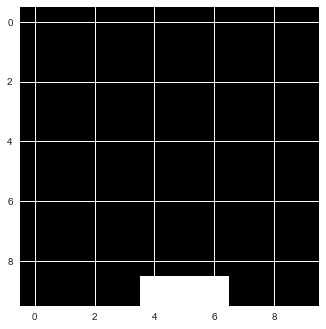

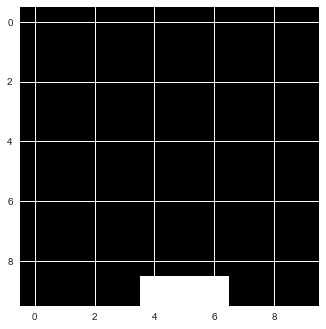

In [15]:
test(model)

## Evaluating progress

That demo is pretty impressive huh? Before we end this little excursion, let's have a closer look at how our model actually did at learning. Earlier, we saved the history of victories. Now we can plot the moving average of the difference, that is, how many additional victories did the model score per extra game. 1 extra victory per game means the model wins every game (it catches every fruit), 0 means it looses all of them. As you can see the model approaches a 100% victory rate over time. After 4000 plays, the model wins relatively consistently. The random drops in performance are likely due to the random choice epsilon that are made from time to time. A better model would get closer to 100% faster.

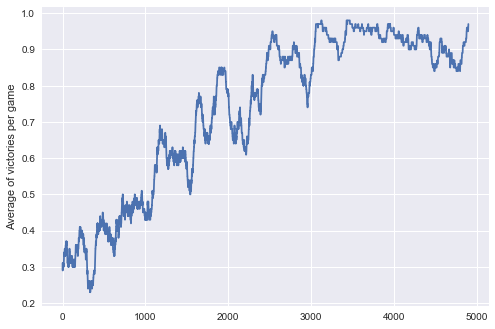

In [12]:
def moving_average_diff(a, n=100):
    diff = np.diff(a)
    ret = np.cumsum(diff, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average_diff(hist))
plt.ylabel('Average of victories per game')
plt.show()